In [12]:
import tensorflow as tf
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

import gym
from gym import spaces
from gym.utils import seeding
from stable_baselines.common.env_checker import check_env
from stable_baselines import PPO2
from stable_baselines.common.policies import MlpPolicy

import numpy as np
from ads_utils import load_data, plot, Environment

from tqdm import tqdm

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



https://github.com/notadamking/Stock-Trading-Environment/blob/master/env/StockTradingEnv.py
The code follows some of this implementation. 


In [14]:
INITIAL_BALANCE = 1_000_000
PAST_DAYS = 5
        
'''NOTE: there is no train/test split yet'''            
data = load_data([2])

fake = np.linspace(100, 200, len(data))
data['close'] = fake

env = Environment(data.close.to_list(), balance=INITIAL_BALANCE, past_days=PAST_DAYS)
env

Balance: $1000000, Price: $100.05, Position: 1

In [18]:
# It will check your custom environment and output additional warnings if needed
check_env(env)
env.reset()

array([1.00009715e+02, 1.00019431e+02, 1.00029146e+02, 1.00038861e+02,
       1.00048577e+02, 1.00000000e+06, 1.00000000e+00])

The model used is PPO2 

#### Short excerpt from docs: 
The Proximal Policy Optimization (PPO) algorithm combines ideas from A2C (having multiple workers) and TRPO (it uses a trust region to improve the actor).

#### Link to doc:
https://stable-baselines.readthedocs.io/en/master/modules/ppo2.html

* there's other actor-critic based models to implement as well


PS: I have yet to know how to interpret the results below

In [27]:
model = PPO2(MlpPolicy, env, verbose=1)

model.learn(total_timesteps=1000) 

Wrapping the env in a DummyVecEnv.
--------------------------------------
| approxkl           | 0.0007164293  |
| clipfrac           | 0.0           |
| explained_variance | 0             |
| fps                | 342           |
| n_updates          | 1             |
| policy_entropy     | 1.0977955     |
| policy_loss        | -0.0033941637 |
| serial_timesteps   | 128           |
| time_elapsed       | 0             |
| total_timesteps    | 128           |
| value_loss         | 0.5787721     |
--------------------------------------
-------------------------------------
| approxkl           | 0.0010295231 |
| clipfrac           | 0.0          |
| explained_variance | 5.96e-08     |
| fps                | 1518         |
| n_updates          | 2            |
| policy_entropy     | 1.0914       |
| policy_loss        | -0.004410303 |
| serial_timesteps   | 256          |
| time_elapsed       | 0.374        |
| total_timesteps    | 256          |
| value_loss         | 0.59399253   |
--

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:12<00:00, 801.53it/s]


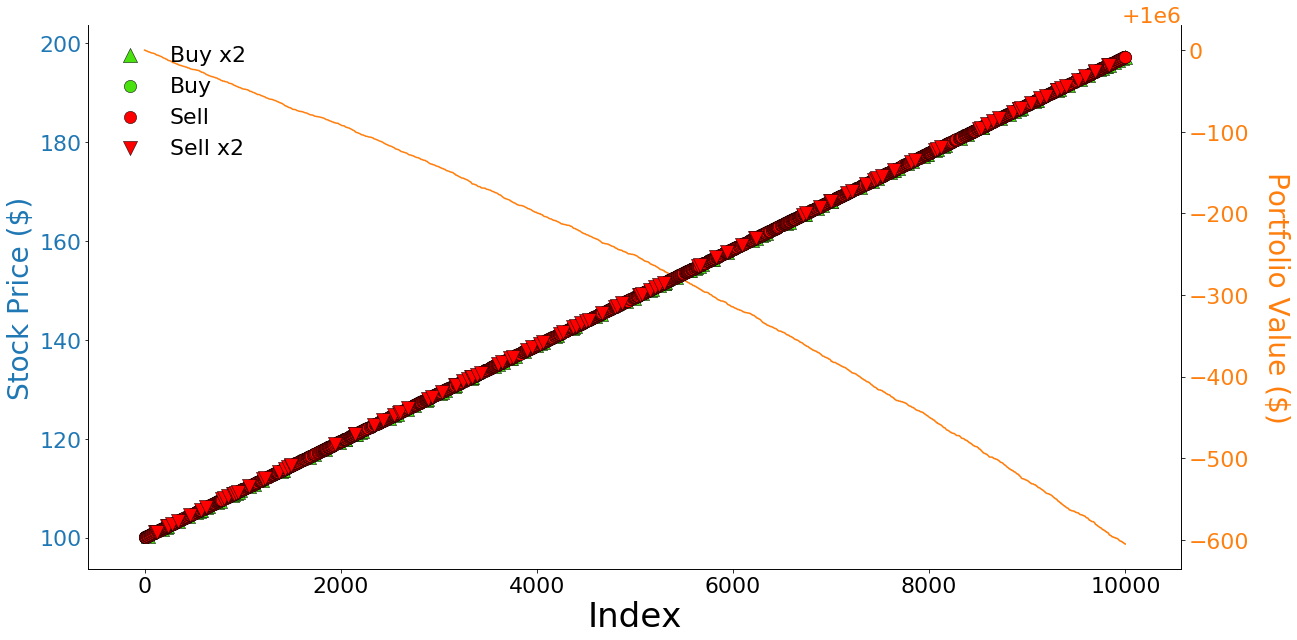

In [58]:
obs = env.reset()
#env = Environment(test_data, INITIAL_BALANCE)

prices = []
balances = []
rewards = []
actions = []
for i in tqdm(range(10000)):
    action, _states = model.predict(obs)
    
    obs, reward, done, _ = env.step(action)
    
    actions.append(action)
    rewards.append(reward)
    balances.append(obs[-2])

    prices.append(obs[PAST_DAYS-1]) # current timestep's closing price
    env.save_portfolio()
    
    if done:
        break
        
portfolio_values = np.array(balances) + (np.array(actions) - 1) * np.array(prices)

plot(prices, actions, portfolio_values[-10000:], right_y_adjust=1.1)


- sometimes, the portfolio values goes to negative :OOOO

In [68]:
import gym
import random
from keras import Sequential
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.activations import relu, linear

import numpy as np
env = Environment(data.close.to_list(), INITIAL_BALANCE)
env.seed(0)
np.random.seed(0)

class DQN:

    """ Implementation of deep q learning algorithm """

    def __init__(self, action_space, state_space):

        self.action_space = action_space
        self.state_space = state_space
        self.epsilon = 1.0
        self.gamma = .99
        self.batch_size = 64
        self.epsilon_min = .01
        self.lr = 0.001
        self.epsilon_decay = .996
        self.memory = deque(maxlen=100)
        self.model = self.build_model()

    def build_model(self):

        model = Sequential()
        model.add(Dense(150, input_dim=self.state_space, activation=relu))
        model.add(Dense(120, activation=relu))
        model.add(Dense(self.action_space, activation=linear))
        model.compile(loss='mse', optimizer=Adam(lr=self.lr))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def get_action(self, state):

        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space)
        action_values = self.model.predict(state)
        return np.argmax(action_values[0])

    def replay(self):

        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        targets = rewards + self.gamma*(np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.model.predict_on_batch(states)
        ind = np.array([i for i in range(self.batch_size)])
        targets_full[[ind], [actions]] = targets

        self.model.fit(states, targets_full, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


def train_dqn(agent, episodes):

    rewards = []
    for e in tqdm(range(episodes)):
        state = env.reset()
        state = np.reshape(state, (1, 7))
        score = 0
        max_steps = 300
        for i in range(max_steps):
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            score += reward
            next_state = np.reshape(next_state, (1, 7))
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            agent.replay()
            if done:
                #print("episode: {}/{}, score: {}".format(e, episodes, score))
                break
        rewards.append(score)

    return loss

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Box(0.0, inf, (7,), float32)
Discrete(3)


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:04<00:00,  1.24s/it]


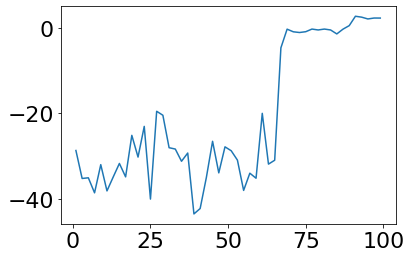

In [69]:
from tqdm import tqdm
print(env.observation_space)
print(env.action_space)
agent = DQN(env.action_space.n, env.observation_space.shape[0])
loss = train_dqn(agent, episodes=100)
plt.plot([i+1 for i in range(0, len(loss), 2)], loss[::2])
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 850.42it/s]


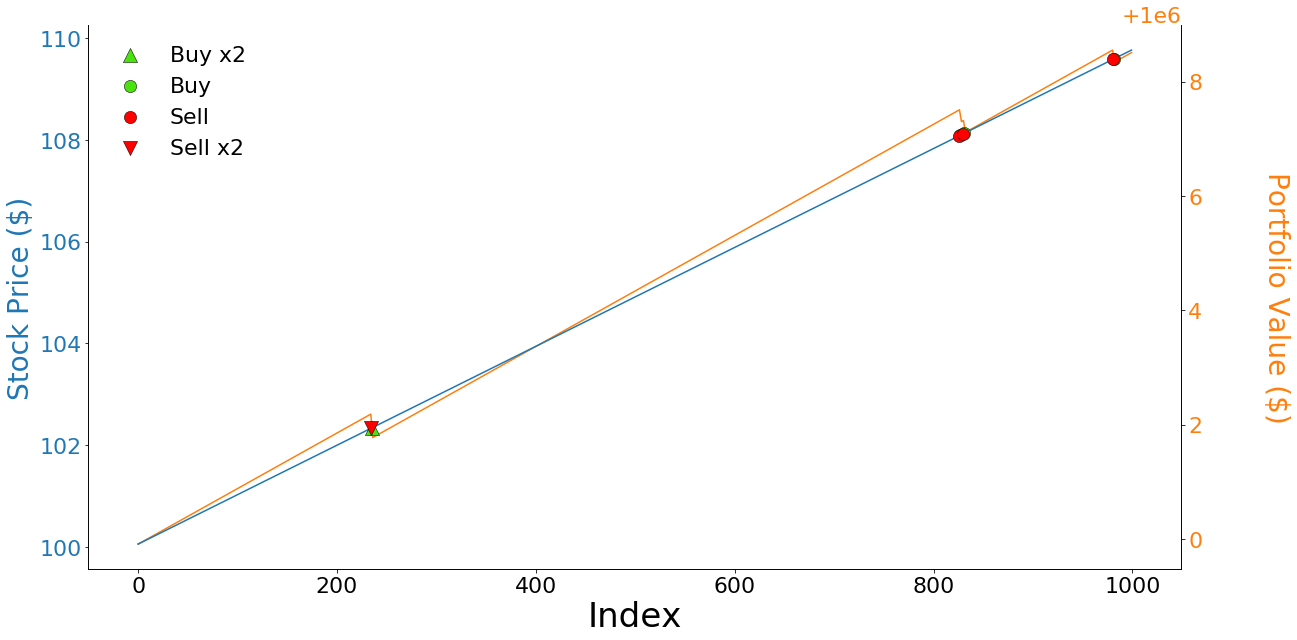

In [73]:
state = env.reset()
state = np.reshape(state, (1, 7))

prices = []
balances = []
rewards = []
actions = []
n_ticks = 1000
for i in tqdm(range(n_ticks)):
    action = agent.get_action(state)
    
    next_state, reward, done, _ = env.step(action)
    
    actions.append(action)
    rewards.append(reward)
    balances.append(next_state[-2])

    prices.append(next_state[PAST_DAYS-1]) # current timestep's closing price
    env.save_portfolio()
    
    next_state = np.reshape(next_state, (1, 7))
    state = next_state
    
    if done:
        break
        
portfolio_values = np.array(balances) + (np.array(actions) - 1) * np.array(prices)

plot(prices, actions, portfolio_values[-n_ticks:], right_y_adjust=1.1)